In [27]:
import torch
import torchvision

In [28]:
train_dataset = torchvision.datasets.MNIST(root='MNIST', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='MNIST', train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [29]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [30]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [31]:
images, labels = iter(train_loader).next()

In [32]:
images.shape

torch.Size([128, 1, 28, 28])

In [33]:
labels.shape

torch.Size([128])

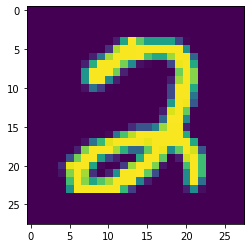

In [34]:
import matplotlib.pyplot as plt

plt.imshow(images[0].view(28, 28))

In [35]:
labels[0].item()

2

## RNN Model

In [36]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [37]:
input_size = 28
sequential_length = 28
num_layers = 2
hidden_size = 256
num_classes = 10
learning_rate = 0.01

In [38]:
import torch.nn as nn

In [39]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)    # batch_size, channel, height, width
        self.fc = nn.Linear(hidden_size * sequential_length, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)    # give hidden layer to RNN
        out = out.reshape(out.shape[0], -1) # 128, 7168(28*28)
        out = self.fc(out)
        return out

In [40]:
net = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [41]:
print(net(images[0].to(device)))
print(net(images[0].to(device)).max(1))
print(net(images[0].to(device)).max(1)[1])

tensor([[-0.0177, -0.0058,  0.0223,  0.0049, -0.0077,  0.0368,  0.0456, -0.0419,
         -0.1141,  0.0481]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([0.0481], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([9], device='cuda:0'))
tensor([9], device='cuda:0')


In [46]:
criterion = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [44]:
epochs = 5

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

for epoch in range(epochs):
    # Train
    net.train()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images.squeeze(1))    # 128, 1, 28, 28 => 128, 28, 28
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_acc += (outputs.max(1)[1] == labels).sum().item()
        train_loss += loss
    avg_train_acc = train_acc / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader.dataset)

    # Evaluation
    net.eval()
    with torch.no_grad():
        test_loss = 0
        test_acc = 0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = net(images.squeeze(1))    # 128, 1, 28, 28 => 128, 28, 28
            loss = criterion(outputs, labels)

            test_acc += (outputs.max(1)[1] == labels).sum().item()
            test_loss += loss
        avg_test_acc = test_acc / len(test_loader.dataset)
        avg_test_loss = test_loss / len(test_loader.dataset)
    
    train_acc_list.append(avg_train_acc)
    train_loss_list.append(avg_train_loss)
    test_acc_list.append(avg_test_acc)
    test_loss_list.append(avg_test_loss)

    print(f'Epoch:{epoch+1}/{epochs}, Train Acc:{avg_train_acc:.4f}, Train Loss:{avg_train_loss:.4f}, Test Acc:{avg_test_acc:.4f}, Test Loss:{avg_test_loss:.4f}')


Epoch:1/5, Train Acc:0.1010, Train Loss:0.2755, Test Acc:0.1028, Test Loss:0.2299
Epoch:2/5, Train Acc:0.0993, Train Loss:0.2449, Test Acc:0.1028, Test Loss:0.2919
Epoch:3/5, Train Acc:0.1003, Train Loss:0.2843, Test Acc:0.1028, Test Loss:0.3594
Epoch:4/5, Train Acc:0.1014, Train Loss:0.2979, Test Acc:0.0982, Test Loss:0.3446
Epoch:5/5, Train Acc:0.0992, Train Loss:0.2610, Test Acc:0.1010, Test Loss:0.2918
